In [257]:
from langgraph.graph import StateGraph,START,END
from langchain_community.document_loaders import PyPDFLoader
from typing import TypedDict, Annotated
import operator
from pydantic import  BaseModel,Field
from langchain_groq import ChatGroq
from langchain_ollama import OllamaLLM,ChatOllama
from dotenv import  load_dotenv
from IPython.display import Image

In [258]:
load_dotenv()

True

In [259]:
class EvaluationSchema(BaseModel):
    feedback : str = Field(description="Detailed Feedback")
    score : int = Field(description="give the score out of 100", ge=0, le=100)

In [ ]:
# model = ChatGroq(model="llama-3.1-8b-instant")
model = ChatOllama(model="llama3")
structured_output_model = model.with_structured_output(EvaluationSchema)

In [261]:
class ResumeState(TypedDict):
    path : str
    content : str
    skills_feedback : str
    experience_feedback : str
    projects_feedback : str
    overall_feedback : str
    individual_score : Annotated[list[int], operator.add]
    avg_score : float

In [262]:
# node which extracts content from the given pdf path
def extract_content(state : ResumeState):
    loader = PyPDFLoader(state["path"])
    resume_content = []
    for page in loader.load():
        resume_content.append(page.page_content)
    return {"content" : " ".join(resume_content)}


In [ ]:
job_desc = """
Key Skills
Data ScienceGenerative AiPython
Predictive ModelingNvidia TensorrtMachine LearningNVIDIA Gen AI
\n\n
Experience: 36 years in Data Science and AI/ML/DL domain.
Hands-on experience in Generative AI and Deep Learning.
Strong programming skills in Python and familiarity with Linux/Windows environments.
Proficiency with data science toolkits: TensorFlow, Keras, PyTorch, Pandas, NumPy, etc.
Understanding of AI tool stack: NeMo Framework, NIMs.
Certifications: Preferably NVIDIA Certified Associate on GenAI.
Exposure to GenAI frameworks: LangChain, LlamaIndex, LangGraph, CrewAI, Nemo Agent Toolkit (NAT).
Knowledge of DL/GenAI algorithms: Transformers, CNN, RNN, etc.
Experience with NLP, Large Language Models, and multi-modal models like GPT, LLaMa, Mistral, Qwen, Nemotron.
Familiarity with Cloud platforms: Azure, AWS, or GCP.
Experience with Git, Docker, and Kubernetes.
Strong problem-solving and analytical skills.
"""


def evaluate_skills(state : ResumeState):
    prompt = f"""You are a Resume Evaluator. Extract the **key skills** from the resume and evaluate it with job description and assign a score out of 100

    \n\njob description = {job_desc}
    \n resume content = {state['content']}"""
    output = structured_output_model.invoke(prompt)
    return {"skills_feedback":output.feedback, "individual_score":[output.score]}

In [264]:
def evaluate_experience(state : ResumeState):
    prompt = f"""You are a Resume Evaluator. Extract the **experience** from the resume and evaluate it with job description and assign a score out of 100

    \n\njob description = {job_desc}
    \n resume content = {state['content']}"""
    output = structured_output_model.invoke(prompt)
    return {"experience_feedback":output.feedback, "individual_score":[output.score]}

In [265]:
def evaluate_projects(state : ResumeState):
    prompt = f"""You are a Resume Evaluator. Extract the **projects** from the resume and check its feature, techstacks and solution to the real world problem and assign a score out of 100
    
    \n\njob description = {job_desc}
    \n resume content = {state['content']}"""
    output = structured_output_model.invoke(prompt)
    return {"projects_feedback":output.feedback, "individual_score":[output.score]}

In [266]:
def final_evaluation(state : ResumeState):
    prompt = f"""Based on the following feedbacks, create a summarized feedback

    \n\nskills feedback = {state['skills_feedback']}\nexperience feedback = {state['experience_feedback']}\nproject feedback = {state['projects_feedback']}"""
    output = structured_output_model.invoke(prompt)
    avg_score = sum(state['individual_score']) / len(state['individual_score'])
    return {"overall_feedback":output.feedback, "avg_score":avg_score}

In [267]:
graph = StateGraph(ResumeState)

graph.add_node("extract_content",extract_content)
graph.add_node("evaluate_skills",evaluate_skills)
graph.add_node("evaluate_experience",evaluate_experience)
graph.add_node("evaluate_projects",evaluate_projects)
graph.add_node("final_evaluation",final_evaluation)

graph.add_edge(START, "extract_content")
graph.add_edge("extract_content","evaluate_skills")
graph.add_edge("extract_content","evaluate_experience")
graph.add_edge("extract_content","evaluate_projects")
graph.add_edge("evaluate_skills","final_evaluation")
graph.add_edge("evaluate_experience","final_evaluation")
graph.add_edge("evaluate_projects","final_evaluation")
graph.add_edge("final_evaluation",END)

workflow = graph.compile()

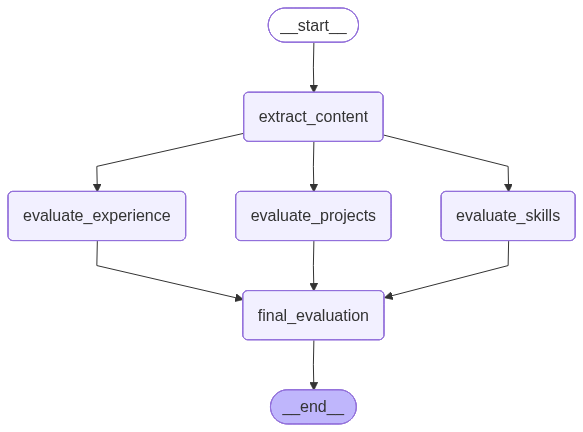

In [268]:
Image(workflow.get_graph().draw_mermaid_png())

In [269]:
initial_state = {"path" : "./resume2.pdf"}
final_state = workflow.invoke(initial_state)

In [270]:
final_state

{'path': './resume2.pdf',
 'content': "First LastMachine Learning EngineerPhoenix, Ariizona  •  +1-234-456-789  •  professionalemail@resumeworded.com  •  linkedin.com/in/username\nMachine learning engineer with 10 years of experience implementing statistical machine learning solutions anddemandforecastingmodelstoimproveforecast accuracy. Keyachievement: optimizedpersonalizationalgorithmsfor 25+ applications with 372K users.\nRELEVANT WORK EXPERIENCE\n_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ Resume Worded, New York, NY 2015 – PresentMachine Learning Engineer\n● Tracked the health of 15+ robots using React/Redux with NodeJS backend and Python scripts, whichcollected 100TB of data from its sensors.● Designed a deep learning model to detect and classify anomalies in the manufacturing process of 34+industrial rob